In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
#sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix , classification_report
from IPython.core.display import display, HTML

### define function to display images

In [2]:
def show_image_samples(gen):
    # get the class dictionary 
    class_dict=gen.class_indices
    # get the dictionary kerys into a list ["COVID", "NON-COVID"]
    class_names=list( class_dict.keys()) 
    
    images,labels=next(gen) # get a sample batch from the generator   
    # set plot figure size
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        # add subplots into the figure
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        # get the target label as 0 or 1
        index=int(labels[i])
        # get the correspoding class name covid or non-covid
        class_name=class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

### define function to plot training data

In [3]:
def tr_plot(tr_data, start_epoch):
    
    #Plot the training and validation data
    
    # get the accuracy , loss , validation_accuracy , validation_loss from the keras history object
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
        
    # get the minimum val loss and the highest  val accuracy 
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    
    plt.style.use('fivethirtyeight')
    
    # get the corresponding best epoch for minimum loss and the best accuracy
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    
    # plot traning and validation loss
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    
    # set plot title
    axes[0].set_title('Training and Validation Loss')
    
    # set plot x and y labels
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # plot the training and validation accuracy
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    
    # set plot title
    axes[1].set_title('Training and Validation Accuracy')
    
    # set plot x and y labels
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

### input an image and get the shape

(512, 512)


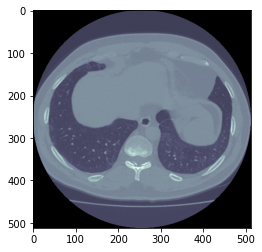

In [4]:
fpath=r'COVID-19-CT-scan-slice-dataset/curated_data/curated_data/1NonCOVID/16_Morozov_study_0001_12.png'
img=plt.imread(fpath)
print (img.shape)
plt.imshow(img , cmap='bone')

In [5]:
# base directory
sdir=r'COVID-19-CT-scan-slice-dataset/curated_data/curated_data'
filepaths=[]
labels=[]

# label map dictionary
label_map={
    "1NonCOVID":"NON-COVID" ,
    "2COVID":"COVID"
}

# get the sub directories from the main base directory
classlist=os.listdir(sdir)

# iterate over every sub directory
for klass in classlist:
    if(klass != "3CAP"):
        classpath=os.path.join(sdir, klass)
        # get the path list of every image
        flist=os.listdir(classpath)
        for f in flist:
            # append image paths and labels into lists
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label_map[klass])
# create pandas data frame using filenames and labels
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
# dataset statistics number of samples for each class type covid and non-covid
balance=df['labels'].value_counts()
print (balance)



                                           filepaths     labels
0  COVID-19-CT-scan-slice-dataset/curated_data/cu...  NON-COVID
1  COVID-19-CT-scan-slice-dataset/curated_data/cu...  NON-COVID
2  COVID-19-CT-scan-slice-dataset/curated_data/cu...  NON-COVID
3  COVID-19-CT-scan-slice-dataset/curated_data/cu...  NON-COVID
4  COVID-19-CT-scan-slice-dataset/curated_data/cu...  NON-COVID
COVID        7590
NON-COVID    6893
Name: labels, dtype: int64


make a train dataframe of the for  filename label

### data set is very unbalanced. Use only 2618 samples from each class

In [6]:
file_count = 6893   # file count from above result
train_val_samples ,test_samples = [] , []
for category in df['labels'].unique():    
    #get each class type covid , non-covid
    category_slice = df.query("labels == @category")    
    # get total file list corresponding into each class
    file_list = category_slice.sample(file_count, replace=False,random_state=1)
    
    # get train and validation samples
    train_val_samples.append(  file_list[670:] )
    # get test samples from each class type --> 670 samples each
    test_samples.append( file_list[:670] )
 
# define each train and test data frames
df_train = pd.concat(train_val_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
df_test = pd.concat( test_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print ( "\nTrain File Label Counts:\n" , df_train['labels'].value_counts()) # check to see each class has 200 samples
print ( "\nTest File Label Counts:\n" , df_test['labels'].value_counts())


Train File Label Counts:
 NON-COVID    6223
COVID        6223
Name: labels, dtype: int64

Test File Label Counts:
 NON-COVID    670
COVID        670
Name: labels, dtype: int64


### partition df into a train_df and a valid_df and make generators

In [7]:
train_split=.8

# split the train and validation split into 80% train and 20% validation
train_df, valid_df=train_test_split(df_train, train_size=train_split, shuffle=True, random_state=123)

# set the image height and width into 224 , 224 since pre trained models trained that on resolution
height=224
width=224
channels=3

# set the batch size to 60
batch_size=60
img_shape=(height, width, channels)
img_size=(height, width)

# define image normalization function which map values to -1 to +1
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1

"""
define keras image generator with augmentation methods  

    shear range --> 0.2
    random zoon --> 0.2
    horizontal flip --> True
    normalization -->  -1 to +1 pixel value range
"""
train_gen=ImageDataGenerator(preprocessing_function=scalar , 
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)

# set the test preprocessing method to normalization step
test_gen=ImageDataGenerator(preprocessing_function=scalar)

# define the data set using the pre defined pandas data frame , class mode set as binary 0 or 1
train_set=train_gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_set=test_gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_set=test_gen.flow_from_dataframe( df_test ,  x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

train_steps=int(len(train_set.labels)/batch_size)
test_steps=int(len( df_test )/batch_size) 
valid_steps = int( len(valid_df)/batch_size )

Found 9956 validated image filenames belonging to 2 classes.
Found 2490 validated image filenames belonging to 2 classes.
Found 1340 validated image filenames belonging to 2 classes.


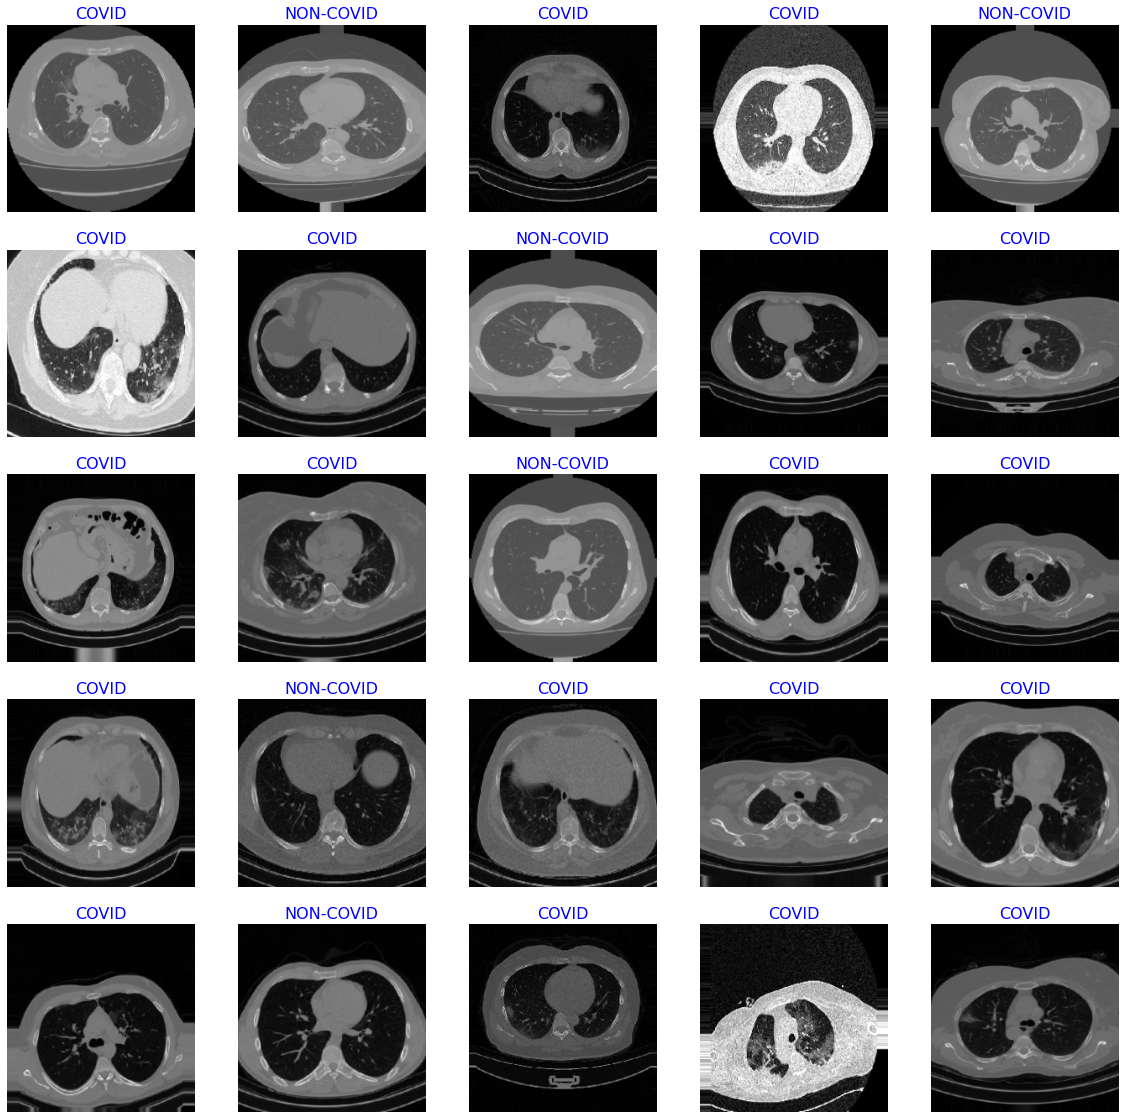

In [8]:
show_image_samples(train_set)

### create the model

In [10]:
# get the class dictionary
class_dict=train_set.class_indices
classes=list( class_dict.keys())

# class count set to 1 as this is binary classification
class_count=1

# get the pre trained model names InceptionResNetv2
model_name='InceptionResNetV2'

# load the model from keras pre tained model repo
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output

# add new layer with batchnoarmlization
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

# add dense layer with 256 hidden units with activation 'relu'
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016) , bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)

# add dropout layer with rate 0.3
x=Dropout(rate=.3, seed=123)(x)        

# add final dense layer with output size to 1 with sigmoid activation
output=Dense(class_count, activation='sigmoid')(x)

# define the model
model=Model(inputs=base_model.input, outputs=output)

# set the initial learning rate as 0.001 since we are adjesting the learning rate while model traning
initial_learning_rate = .001

# model compile using Adamax and binary_crossentropy loss 
model.compile(Adamax(learning_rate= initial_learning_rate ), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [85]:
#model.summary()

### instantiate the calback and train the model

In [11]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import math

epochs =35
batches=train_steps

# define a function to learning rate decay over time
def lr_step_decay(epoch, lr):
    drop_rate = 0.8
    epochs_drop = 5.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# set a model checkpoint to save only the best model
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# set the callbacks into learning rate decay and save models using checkpoint
callbacks=[LearningRateScheduler(lr_step_decay, verbose=1) , checkpoint]

# train the model
history=model.fit(x=train_set, epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_set ,  shuffle=False,  initial_epoch=0)

Epoch 1/35

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
166/166 [==============================] - 1986s 12s/step - loss: 4.2878 - accuracy: 0.9245 - auc: 0.9649 - val_loss: 2.5298 - val_accuracy: 0.9578 - val_auc: 0.9892

Epoch 00001: val_loss improved from inf to 2.52977, saving model to model.h5
Epoch 2/35

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
166/166 [==============================] - 1858s 11s/step - loss: 1.7735 - accuracy: 0.9631 - auc: 0.9884 - val_loss: 1.1940 - val_accuracy: 0.9622 - val_auc: 0.9930

Epoch 00002: val_loss improved from 2.52977 to 1.19405, saving model to model.h5
Epoch 3/35

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
166/166 [==============================] - 1886s 11s/step - loss: 0.8546 - accuracy: 0.9717 - auc: 0.9938 - val_loss: 0.6029 - val_accuracy: 0.9703 - val_auc: 0.9932

Epoch 00003: val_loss improved from 1.19405 to 0.60289, saving model to model.h5
Epoch 4/35

Epoch 00004


Epoch 00026: val_loss improved from 0.05081 to 0.05046, saving model to model.h5
Epoch 27/35

Epoch 00027: LearningRateScheduler setting learning rate to 0.0003276800000000001.
166/166 [==============================] - 1911s 12s/step - loss: 0.0044 - accuracy: 0.9994 - auc: 0.9999 - val_loss: 0.0724 - val_accuracy: 0.9859 - val_auc: 0.9946

Epoch 00027: val_loss did not improve from 0.05046
Epoch 28/35

Epoch 00028: LearningRateScheduler setting learning rate to 0.0003276800000000001.
166/166 [==============================] - 8877s 54s/step - loss: 0.0042 - accuracy: 0.9990 - auc: 1.0000 - val_loss: 0.0738 - val_accuracy: 0.9847 - val_auc: 0.9942

Epoch 00028: val_loss did not improve from 0.05046
Epoch 29/35

Epoch 00029: LearningRateScheduler setting learning rate to 0.0003276800000000001.
166/166 [==============================] - 6010s 36s/step - loss: 0.0057 - accuracy: 0.9986 - auc: 1.0000 - val_loss: 0.0715 - val_accuracy: 0.9851 - val_auc: 0.9942

Epoch 00029: val_loss did n

In [12]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])


## Plot the model accuracy, losses and AUC 

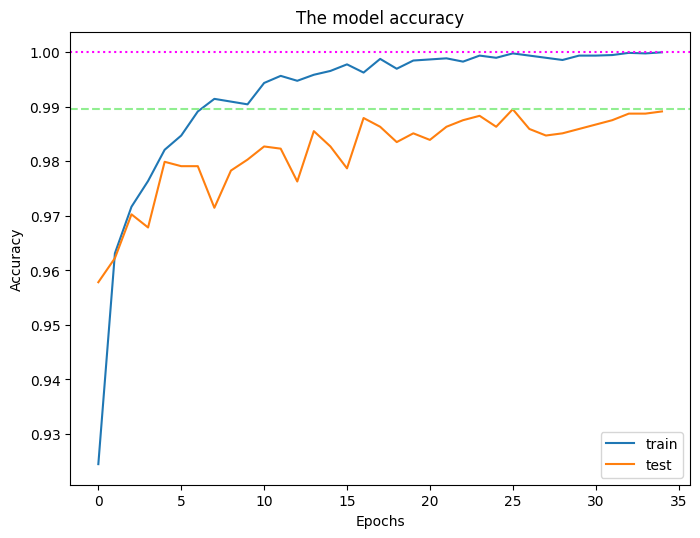

In [40]:
# summarize history for accuracy
plt.figure(figsize=(8,6), dpi=100)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline([max(history.history['accuracy'])], color ="magenta", linestyle =":")
plt.axhline([max(history.history['val_accuracy'])], color ="lightgreen", linestyle ="--")
plt.title('The model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

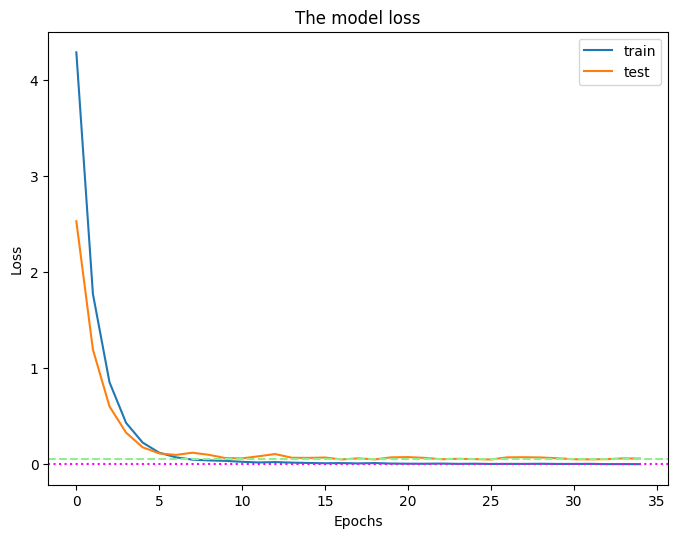

In [41]:
# summarize history for loss
plt.figure(figsize=(8,6), dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axhline([min(history.history['loss'])], color ="magenta", linestyle =":")
plt.axhline([min(history.history['val_loss'])], color ="lightgreen", linestyle ="--")
plt.title('The model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

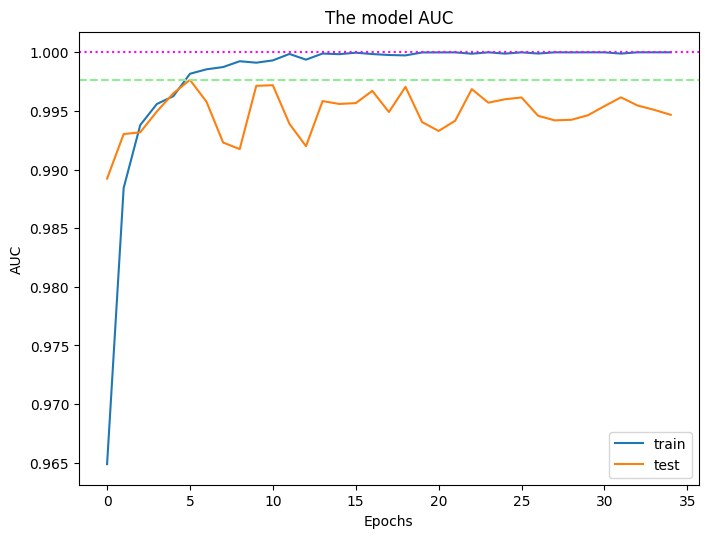

In [44]:
# summarize history for loss
plt.figure(figsize=(8,6), dpi=100)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.axhline([max(history.history['auc'])], color ="magenta", linestyle =":")
plt.axhline([max(history.history['val_auc'])], color ="lightgreen", linestyle ="--")
plt.title('The model AUC')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### Evaluating the model on the test set

In [45]:
# check the model results on test dataset
acc=model.evaluate( test_set ,batch_size=batch_size, steps=test_steps, verbose=1)[1]*100

22/22 [==============================] - 41s 2s/step - loss: 0.0549 - accuracy: 0.9886 - auc: 0.9953


### Loading the best saved model and test on the test dataset

In [46]:
# load the best model from saved weights
best_model = tf.keras.models.load_model("./model.h5")
#best_model.summary()

In [47]:
# evaluate on the test set 
acc=best_model.evaluate(test_set ,batch_size=batch_size, steps=test_steps, verbose=1)[1]*100

22/22 [==============================] - 61s 3s/step - loss: 0.0417 - accuracy: 0.9924 - auc: 0.9961


### Let's make predictions and generate confusion matrix and ROC curve

In [49]:
prediction , target =[] ,[]
# iterate over every batch in the test set
for idx , (i_x , i_y) in enumerate(test_set) :
  if(idx <= test_steps):
      # predict the output using model predict
      model_pred = model.predict( i_x )
      for i_pred , i_target in zip(  model_pred , i_y):
          # get the prediction and corresponding target label into lists
          prediction.append( round(i_pred[0]) )
          target.append( i_target )
          if( len(prediction)%100 ==0 ):
                print(len(prediction))
  else: break

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       670
         1.0       0.99      0.99      0.99       670

    accuracy                           0.99      1340
   macro avg       0.99      0.99      0.99      1340
weighted avg       0.99      0.99      0.99      1340



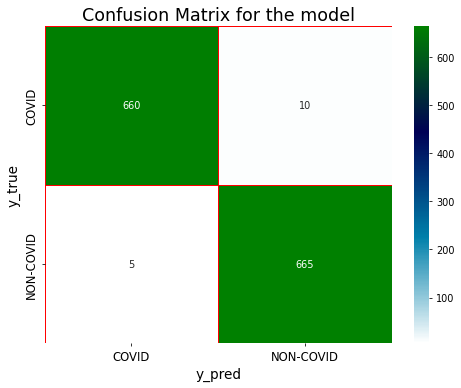

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# convert prediction and target into numpy array
y_pred = np.array(prediction)
y_true = np.array(target)
names=["COVID","NON-COVID"]

print("Classification Report:\n", classification_report(y_true, y_pred))

# create the confusion matrix using sklearn
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(8,6), dpi=70)

# create the confusion matrix visualization using seaborn
sns.heatmap(cm, annot=True, linewidth=1, linecolor="red", fmt=".0f", ax=ax, cmap='ocean_r')
plt.xlabel("y_pred", size= 14)
plt.ylabel("y_true", size= 14)
ax.set_xticklabels(names, size= 12)
ax.set_yticklabels(names, size= 12)
plt.title('Confusion Matrix for the model', size = 18)
plt.savefig('Confusion Matrix for the model')

plt.show()

In [60]:
keras_pred , keras_target =[] ,[]
# iterate over each batch in test set
for idx , (i_x , i_y) in enumerate(test_set) :
  if(idx <= test_steps):
      # get the model prediction for each batch
      model_pred = model.predict( i_x ).ravel()
      for i_pred , i_target in zip(  model_pred , i_y):
          # append each prediction and corresponding target into a list
          keras_pred.append( i_pred )
          keras_target.append( i_target )
          if( len(keras_pred)%100 ==0 ):
                print(len(keras_pred))
  else: break

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [82]:
from sklearn.metrics import roc_curve
from yellowbrick.classifier import ROCAUC

# get the roc curve using sklearn library
fpr_keras, tpr_keras, thresholds_keras = roc_curve( keras_target , keras_pred )

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

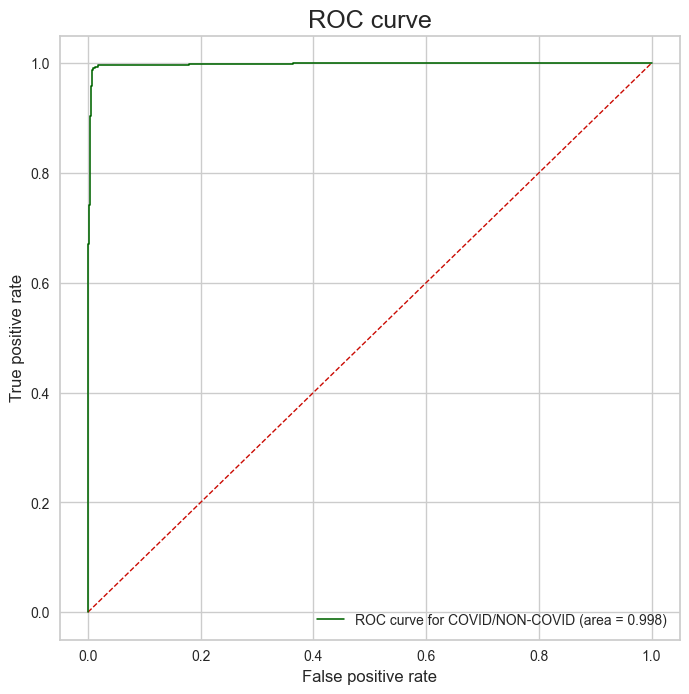

In [97]:
fig = plt.figure(figsize=(8,8), dpi=100)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--', lw=1)
# plot the roc curve
plt.plot(fpr_keras,tpr_keras,color='darkgreen',lw=1.15, label='ROC curve for COVID/NON-COVID (area = {:.3f})'.format(auc_keras))
# set the xlabel and ylabel
plt.xlabel('False positive rate', size=12)
plt.ylabel('True positive rate', size=12)
plt.title('ROC curve', size=18)
plt.legend(loc=4)
plt.show()

# *Covid-19 progression pattern*

According to the paper: "*Time Course of Lung Changes at Chest CT during Recovery from Coronavirus Disease 2019 (COVID-19)" (https://pubs.rsna.org/doi/10.1148/radiol.2020200370)*

The common pattern in the COVID progression over time is:

- ***Day 0-4: Ground Glass Opacities (GGO)***
- ***Day 5-8: Crazy Paving & Consolidation***
- ***Day 9-13: Consolidation***
- ***Day>= 14: Residual Ground Glass Opacities & Parenchymal Bands***


Here, we will search for the COVID distinctive characteristics to look into the comnbination of characteristics which appears in the limited number of radiologist studies which is available in the csv file COVID meta-data.

We will be visually contrasting the characteristics by sampling their corresponding CT scan images.

In [98]:
# reading COVID meta data file
df = pd.read_csv('COVID-19-CT-scan-slice-dataset/meta_data_covid.csv', encoding='windows-1252')

In [99]:
# specifiying the search terms we want to look for in the meta data file
search_terms =['consolidation','ground glass','diffuse','bilateral','paving','parenchymal']

In [128]:
    
num = 0
col_list = []
for i in df.columns:
    df[i].astype('str').apply(lambda x: col_list.append(df[i].name)  if any(ele in x.lower() for ele in search_terms)  else 'pass')
    
print("Number of rows containing the search_terms: ",len(col_list)) 
print("The columns containing the search_terms: ",set(col_list))

relavant_columns = list(set(col_list))
from collections import Counter
Counter(col_list)

Number of rows containing the search_terms:  946
The columns containing the search_terms:  {'Severity', 'Other diseases', 'Presentation', 'finding', 'Case Discussion'}


Counter({'Case Discussion': 265,
         'Other diseases': 7,
         'Presentation': 7,
         'Severity': 56,
         'finding': 611})

In [129]:
def reformatting(x):
# relpace missing values with '-'
    try:
        return str(x)
    except:
        return '-'

def filtered_columns(column_name,terms):
    df[column_name] = df[column_name].iloc[:].apply(lambda x : reformatting(x)) 
    filterred_column = df.loc[df[column_name].str.lower().str.contains(terms)]
    print(column_name,len(filterred_column))
    return filterred_column
    
finding = filtered_columns('finding','|'.join(search_terms))
Presentation = filtered_columns('Presentation','|'.join(search_terms))
Discussion = filtered_columns('Case Discussion','|'.join(search_terms))
Severity = filtered_columns('Severity','|'.join(search_terms))
other = filtered_columns('Other diseases','|'.join(search_terms))

finding 611
Presentation 7
Case Discussion 265
Severity 56
Other diseases 7


In [130]:
#All the rows with the search terms
merged = pd.merge(pd.merge(pd.merge(pd.merge(finding, Presentation, how="outer"), 
                                    Discussion, how="outer"), 
                                    Severity, how="outer"), 
                                    other, how="outer")
merged[relavant_columns]

Severity  \
0                                                  nan   
1                                                  nan   
2                                                  nan   
3                                                  nan   
4                                                  nan   
..                                                 ...   
623  Patchy lesion of Crazy Paving Pattern in right...   
624                                               mild   
625                                               mild   
626                                             severe   
627                                             severe   

                Other diseases  \
0                          nan   
1                          nan   
2                          nan   
3                          nan   
4                          nan   
..                         ...   
623                        nan   
624  bilateral patchy patterns   
625  bilateral patchy patterns   
626  bilateral patchy patterns   
627  bilateral patchy patterns   

                                         Presentation  \
0    A physician with fever and sudden-onset dyspnea.   
1    A physician with fever and sudden-onset dyspnea.   
2    A physician with fever and sudden-onset dyspnea.   
3    A physician with fever and sudden-onset dyspnea.   
4    A physician with fever and sudden-onset dyspnea.   
..                                                ...   
623                                               nan   
624                                               nan   
625                                               nan   
626                                               nan   
627                                               nan   

                                               finding  \
0    Multilobar and bilateral ground?glass opacitie...   
1    Multilobar and bilateral ground?glass opacitie...   
2    Multilobar and bilateral ground?glass opacitie...   
3    Multilobar and bilateral ground?glass opacitie...   
4    Multilobar and bilateral ground?glass opacitie...   
..                                                 ...   
623  ['FIGURE 2, Different imaging features for hea...   
624  ['Figure 1. Representative chest radiographic ...   
625  ['Figure 1. Representative chest radiographic ...   
626  ['Figure 1. Representative chest radiographic ...   
627  ['Figure 1. Representative chest radiographic ...   

                                       Case Discussion  
0    This case was of a physician that had a fever ...  
1    This case was of a physician that had a fever ...  
2    This case was of a physician that had a fever ...  
3    This case was of a physician that had a fever ...  
4    This case was of a physician that had a fever ...  
..                                                 ...  
623                                                nan  
624                                                nan  
625                                                nan  
626                                                nan  
627                                                nan  

[628 rows x 5 columns]

## *Counting the combination of lesion types*

We want to count how many from each of lesion type and their combinations exists

Let's find the existence of the lesion type in the case report in a new column.

In [131]:
def new_column(x,i):
            ele = 'GGO'
            if (('ground' in x.lower()) and ('glass' in x.lower())) or ('ggo' in x.lower()):
                merged.loc[merged[i]==x,str(ele)] = str(ele)+', '
            #else:
            #    merged.loc[merged[i]==x,str(ele)] = ''
                    
    

for i in merged.columns:
    merged[i].astype('str').apply(lambda x: new_column(x,i)  if any(ele in x.lower() for ele in search_terms)  else 'pass')

In [132]:
search_terms =['consolidation','diffuse','opacification','bilateral','paving','parenchymal']
def new_column(x,i):
        for ele in search_terms:
            if ele in x.lower():            
                merged.loc[merged[i]==x,str(ele).capitalize()] = str(ele).capitalize()+', '
            #else:
            #    merged.loc[merged[i]==x,str(ele)] = ''
                    
    

for i in merged.columns:
    merged[i].astype('str').apply(lambda x: new_column(x,i)  if any(ele in x.lower() for ele in search_terms)  else 'pass')

## *Lesion types for given cases*
Plotting the number of cases having a particular lesion type from the exsiting reports ~ 796 reports

In [162]:
terms_count = pd.DataFrame((merged.notnull().sum()[-7:]/796)*100 ,columns=['Proportion']).sort_values('Proportion',
                                                                                                      ascending = True)
terms_count.rename(index={'Bilateral':'Bilateral Involvement',
                          'Parenchymal':'Parenchymal Bands',
                          'Paving':'Crazy Paving',
                          'Diffuse':'Diffuse Distribution'},
                   inplace = True)
terms_count.reset_index()
df.rename(index={'alpha': 'mu'})
terms_count.reset_index(inplace = True)
terms_count.rename(columns={'index':'CT Characteristic'},inplace = True)

import plotly.express as px
fig1 = px.bar(terms_count, orientation="h", x='Proportion', y='CT Characteristic',
              width=950, height=600, color = "Proportion", 
              template="plotly_white", color_continuous_scale="Spectral", 
              title="Proportions of CT Characteristics")
fig1.update_layout(hovermode="y")
fig1.show()

## *Concatenating columns*
Concatenating the new columns and counting the number of each new combinations

In [120]:
merged.fillna('', inplace=True)
merged['combinations'] = merged.iloc[:, -1]+merged.iloc[:, -2]+merged.iloc[:, -3]+merged.iloc[:, -4]+merged.iloc[:, -5]+merged.iloc[:, -6]+merged.iloc[:, -7]
merged['combinations'] = merged['combinations'].apply(lambda x: x.lstrip().rstrip(', '))


from collections import Counter
x = Counter(merged['combinations'])
summary = [[l,k] for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)]

In [121]:
from tabulate import tabulate
summary = pd.DataFrame(summary, columns = ['Combination', 'Count']) 

# different combination of the terms and the number of rows they appear in
print(tabulate(summary, headers='keys', tablefmt='psql'))

+----+----------------------------------------------+---------+
|    | Combination                                  |   Count |
|----+----------------------------------------------+---------|
|  0 | Bilateral, Consolidation, GGO                |     203 |
|  1 | Bilateral, GGO                               |     169 |
|  2 | Paving, Opacification, Bilateral, GGO        |     103 |
|  3 | Consolidation, GGO                           |      77 |
|  4 | Consolidation                                |      15 |
|  5 | Bilateral                                    |      12 |
|  6 | Paving, GGO                                  |      10 |
|  7 | Diffuse, Paving, Consolidation, GGO          |       6 |
|  8 | Diffuse, Bilateral, Consolidation, GGO       |       6 |
|  9 | Bilateral, Consolidation                     |       4 |
| 10 | Paving, Consolidation                        |       3 |
| 11 | Paving, Bilateral, GGO                       |       2 |
| 12 | Opacification, Bilateral, Consoli

In [161]:
import plotly.express as px
fig2 = px.bar(summary.sort_values(by='Count'),x='Count',y='Combination', 
              template="plotly_white", height=650, width=950,
              title="Count for all Combinations")
fig2.update_traces(marker_color='darkorange')
fig2.update_layout(hovermode="y")
#summary.sort_values(by ='Count').plot(x="Combination", y="Count", kind="barh")

In [123]:
unique_comnibations = list(set(merged['combinations']))
sample_file_names = pd.DataFrame(
    [ p , merged[merged['combinations'] == p ].reset_index()['File name'].iloc[-1]] for p in unique_comnibations)

sample_file_names.columns=['Combinations','File Name']
sample_file_names

#merged.loc[0,'combinations']
#merged['combinations']

Combinations  \
0                  Opacification, Bilateral, GGO   
1                                    Parenchymal   
2              Diffuse, Bilateral, Consolidation   
3                         Paving, Bilateral, GGO   
4                                  Consolidation   
5            Diffuse, Paving, Consolidation, GGO   
6                Diffuse, Paving, Bilateral, GGO   
7                  Bilateral, Consolidation, GGO   
8                                      Bilateral   
9          Parenchymal, Bilateral, Consolidation   
10                                   Paving, GGO   
11  Opacification, Bilateral, Consolidation, GGO   
12                    Parenchymal, Consolidation   
13                            Consolidation, GGO   
14                         Paving, Consolidation   
15                                       Diffuse   
16        Diffuse, Bilateral, Consolidation, GGO   
17              Paving, Bilateral, Consolidation   
18                      Bilateral, Consolidation   
19         Paving, Bilateral, Consolidation, GGO   
20                                Bilateral, GGO   
21                   Diffuse, Consolidation, GGO   
22         Paving, Opacification, Bilateral, GGO   
23                       Diffuse, Bilateral, GGO   
24                                  Diffuse, GGO   

                                       File Name  
0         17_Zhao_2020.03.03.20030775-p11-91.png  
1      17_Zhao_2020.03.04.20030395-p27-108%0.png  
2      17_Zhao_2020.03.04.20030395-p27-108%8.png  
3     17_Zhao_2020.03.22.20040782-p24-1533-2.png  
4      17_Zhao_2020.02.25.20021568-p24-111%0.png  
5        17_Zhao_2020.03.25.20037721-p27-165.png  
6                         15_Cohen_16689_1_2.png  
7       17_Zhao_2020.02.13.20022673-p13-77%2.png  
8        17_Zhao_2020.03.08.20031658-p15-106.png  
9      17_Zhao_2020.03.04.20030395-p27-108%5.png  
10       17_Zhao_2020.03.30.20047985-p9-56%3.png  
11      17_Zhao_2020.03.03.20030775-p12-93%1.png  
12                        15_Cohen_16745_7_4.png  
13      17_Zhao_2020.02.19.20025023-p20-93%2.png  
14      17_Zhao_2020.03.04.20031047-p13-84%3.png  
15     17_Zhao_2020.03.16.20036145-p19-128-3.png  
16      17_Zhao_2020.03.04.20031047-p14-87%0.png  
17     17_Zhao_2020.03.04.20030395-p27-108%4.png  
18      17_Zhao_2020.03.09.20033118-p20-93%3.png  
19                        15_Cohen_16744_2_2.png  
20     17_Zhao_2020.02.11.20021493-p16-109%1.png  
21     17_Zhao_2020.03.04.20030395-p27-108%6.png  
22  14_Jun_radiopaedia_14_85914_0_case13_103.png  
23      17_Zhao_2020.03.04.20031047-p12-81%1.png  
24        17_Zhao_2020.03.22.20034041-p16-66.png

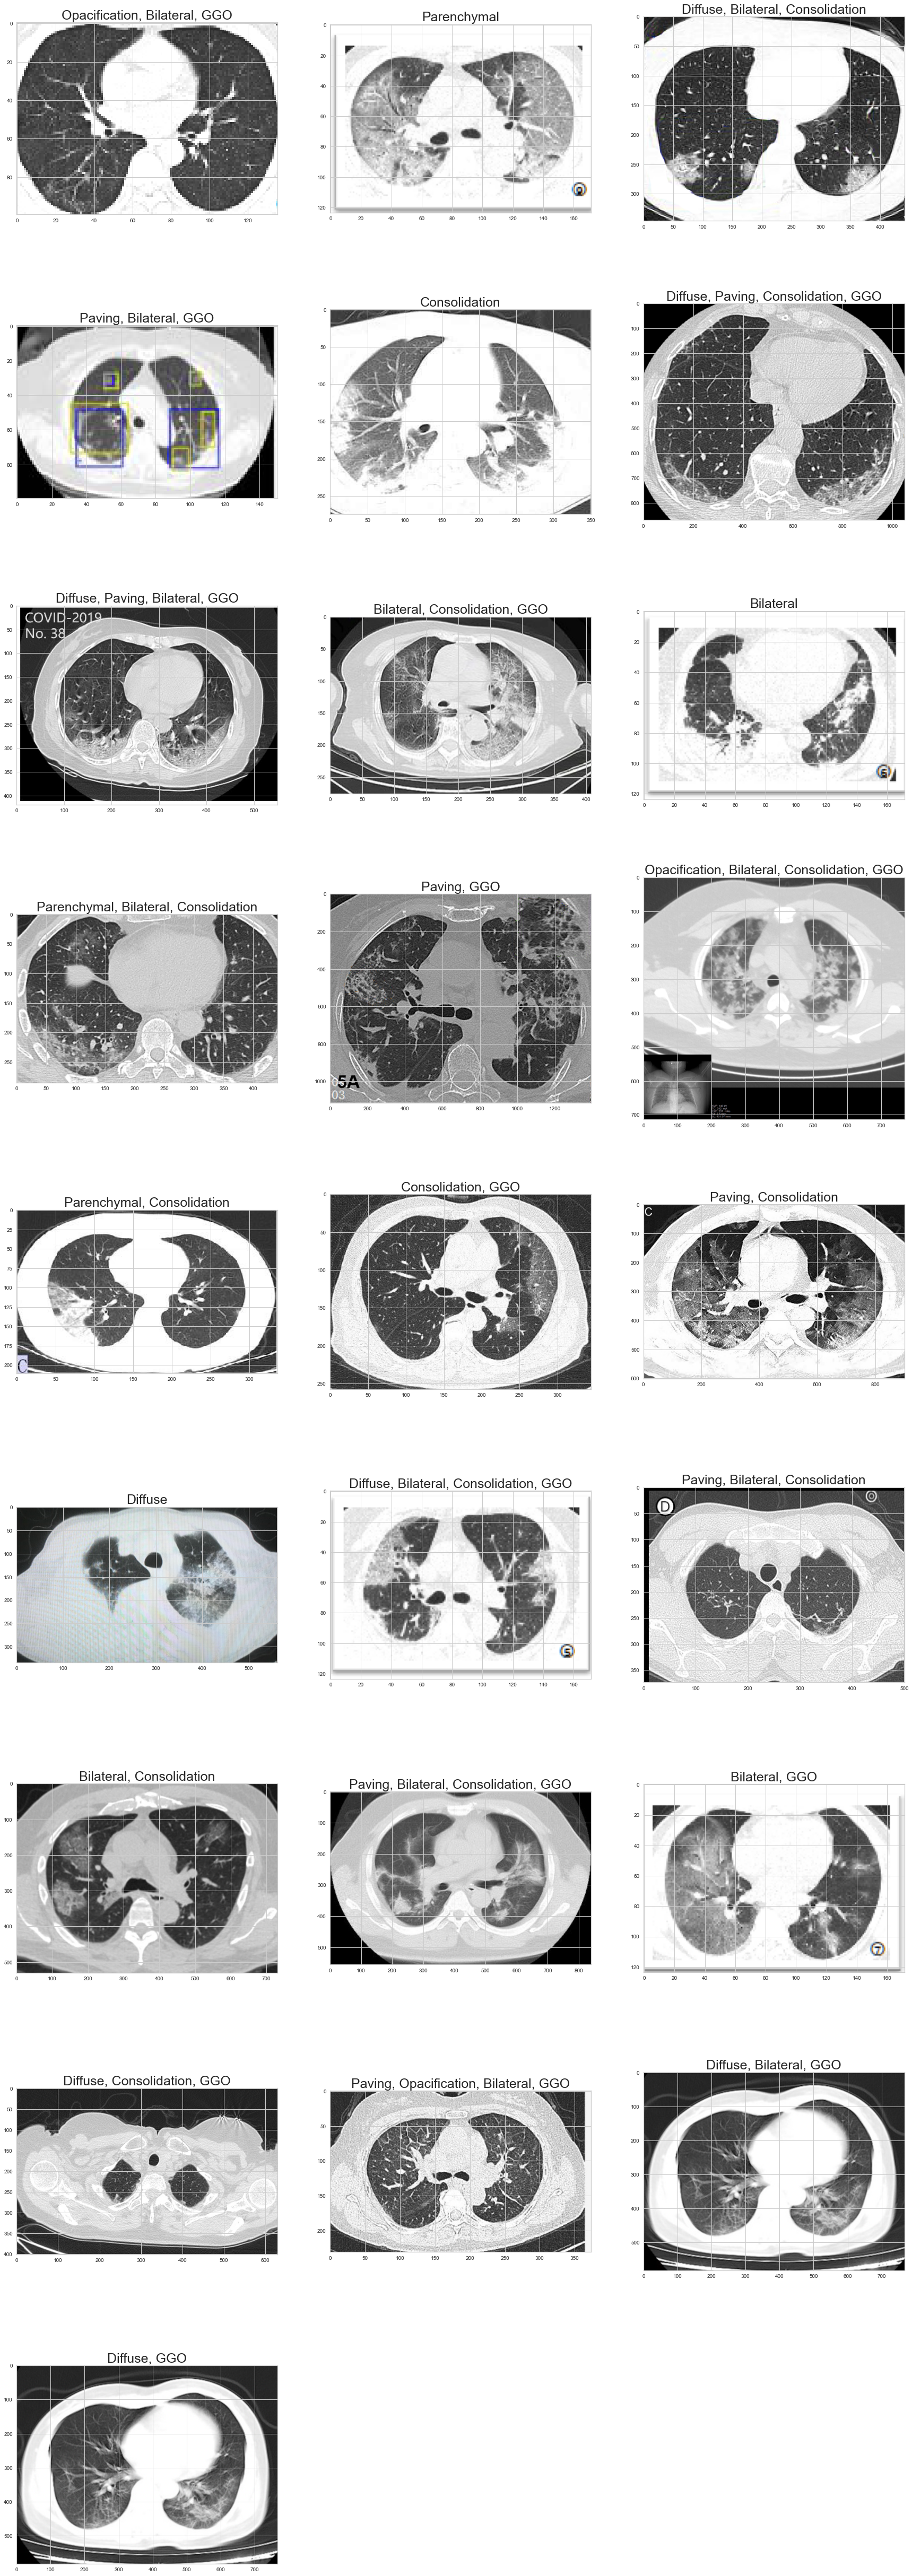

In [126]:
plt.figure(figsize=(30,100))  
for i in range(len(sample_file_names)):
    img = cv2.imread('COVID-19-CT-scan-slice-dataset/curated_data/curated_data/2COVID/'+sample_file_names.loc[i,'File Name'])
    plt.imshow(img)
    plt.subplot(10, 3, i+1)
    plt.imshow(img)
    plt.title(sample_file_names.loc[i,'Combinations'],fontsize=25) 